In [1]:
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import ariel_load
import tqdm
import copy
import importlib
import ariel_diagnostics
train_data = kgs.load_all_train_data()
kgs.sanity_checks_active = False

local


In [5]:
# FGS = []
# AIRS = []
# N_FGS=2500
# N_AIRS=500
# loaders = ariel_load.default_loaders()
# for d in tqdm.tqdm(train_data):
#     for t in d.transits:
#         tt = copy.deepcopy(t)
#         tt.load_to_step(2, d, loaders)
#         for ii in range(tt.data[0].data.shape[0]//N_FGS):
#             FGS.append(cp.mean(tt.data[0].data[N_FGS*ii:(N_FGS)*(ii+1),...],0).get())
#         for ii in range(tt.data[1].data.shape[0]//N_AIRS):
#             AIRS.append(cp.mean(tt.data[1].data[N_AIRS*ii:(N_AIRS)*(ii+1),...],0).get())
# del tt
# FGS = cp.array(FGS)
# AIRS = cp.array(AIRS)
# data = [FGS, AIRS]
# kgs.dill_save(kgs.temp_dir + '/explore_sensor_modes.pickle', data)
data = kgs.dill_load(kgs.temp_dir + '/explore_sensor_modes.pickle')
print([d.shape for d in data])

[(32670, 32, 32), (13310, 32, 282)]


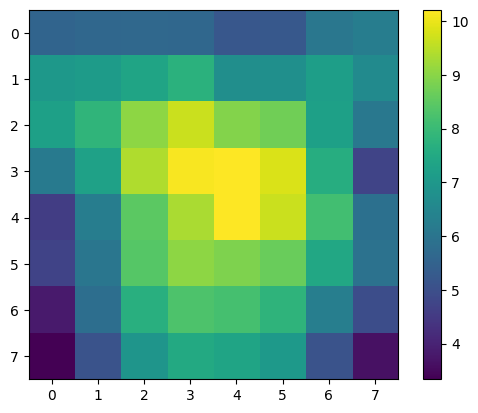

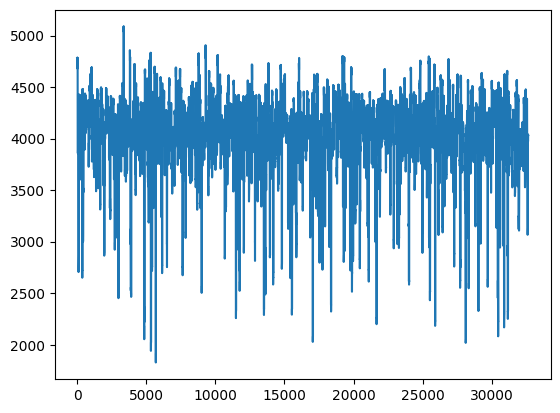

In [6]:
data[0] = data[0][cp.nanmean(data[0],axis=(1,2))<1000,...]
sens_id = 0
data[0] = data[0][:,12:20,12:20]
# vals = cp.nanmean(data[sens_id],(1,2))
# print(cp.nanmean(data[sens_id][:, 16,16]))
# inds = cp.argsort(vals)
# data[sens_id][inds[:-len(inds)/20], 16,16]=cp.nan
# print(cp.nanmean(data[sens_id][:, 16,16]))
#data[sens_id] += 0*np.mean(data[sens_id],2)[:,:,None]
plt.figure()
plt.imshow(cp.log(cp.nanmean(data[sens_id],0)).get())
plt.colorbar()
plt.figure()
plt.plot(cp.nanmean(data[sens_id],axis=(1,2)).get())
#plt.figure()
#plt.plot(cp.nanmean(data[sens_id][:,20:,25:],axis=(1,2)).get())
#cp.argmax(cp.nanmean(data[sens_id][:,20:,25:],axis=(1,2)))


Iteration 1: error = 251201.011291
Iteration 2: error = 154987.681431
Iteration 3: error = 154987.680661
Iteration 4: error = 154987.680661
Converged at iteration 4: error = 154987.680661


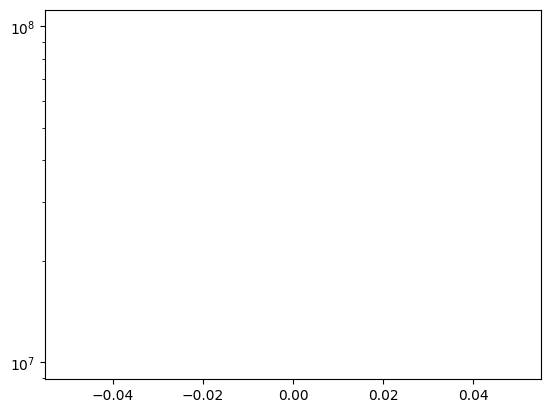

In [7]:
import cupyx.scipy.sparse.linalg as cusparse
def nan_pca(mat, n_components, max_iter=50, tol=1e-6, verbose=False):
    """
    Perform PCA on data with missing values using an alternating least squares approach,
    fitting directly on observed entries (unfilled data) with fully GPU-parallel batch solves.

    Args:
        mat (cp.ndarray): Input data, shape (n_samples, ...). May contain NaNs.
        n_components (int): Number of principal components to retain.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance on reconstruction error change.
        verbose (bool): If True, prints iteration diagnostics.

    Returns:
        W (cp.ndarray): Projected scores (n_samples, n_components).
        C (cp.ndarray): Principal components (n_components, n_features).
    """
    # Flatten per-sample features
    X = cp.array(mat, copy=True)
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)
    mask = (~cp.isnan(X))
    n_features = X.shape[1]    
    X[cp.sum(mask,1)<n_components+1,:] = 0.
    X[:,cp.sum(mask,0)<n_components+1] = 0.
    mask = (~cp.isnan(X))
    X[~mask] = 0.
    
    rng = cp.random.default_rng(seed=42)
    W = rng.standard_normal((n_samples, n_components), dtype=X.dtype)
    C = rng.standard_normal((n_components, n_features), dtype=X.dtype)
    
    mask = mask.astype(X.dtype)  # float mask for weighting

    prev_error = cp.inf
    for itr in range(1, max_iter + 1):
        # === Batch-solve for C: for each j, (W^T M^j W) c_j = W^T (M^j x^j) ===
        # Here M^j is mask[:, j] for feature j
        # Compute A2_batch[j,p,q] = sum_i mask[i,j] * W[i,p] * W[i,q]
        A2_batch = cp.einsum('ip,ij,iq->jpq', W, mask, W)
        # Compute B2_batch[j,p] = sum_i mask[i,j] * W[i,p] * X[i,j]
        B2_batch = cp.einsum('ip,ij,ij->jp', W, mask, X)
        # Solve for C: shape (n_components, n_features)
        C = cp.linalg.solve(A2_batch, B2_batch[..., None]).squeeze(-1).T
        del A2_batch, B2_batch
        C= cp.linalg.qr(C.T)[0].T
        
        # === Batch-solve for W: for each i, (C M_i C^T) w_i = C (M_i x_i) ===
        # Compute A_batch[i,a,c] = sum_j mask[i,j] * C[a,j] * C[c,j]
        A_batch = cp.einsum('aj,ij,cj->iac', C, mask, C)
        # Compute B_batch[i,a] = sum_j mask[i,j] * C[a,j] * X[i,j]
        B_batch = cp.einsum('aj,ij,ij->ia', C, mask, X)
                
        # Solve for W: shape (n_samples, n_components)
        # cp.linalg.solve supports batch: A_batch @ W_batch[...,None] = B_batch[...,None]
        W = cp.linalg.solve(A_batch, B_batch[..., None]).squeeze(-1)
        del A_batch, B_batch
        
        # Compute reconstruction and error
        err = cp.linalg.norm((X - W @ C) * mask)
        if verbose:
            print(f"Iteration {itr}: error = {err:.6f}")
        if abs(prev_error - err) < tol:
            if verbose:
                print(f"Converged at iteration {itr} with error {err:.6f}")
            break
        prev_error = err

    new_shape = list(mat.shape)
    new_shape[0] = C.shape[0]
    C = C.reshape(new_shape)
    S_post = cp.linalg.norm(W, axis=0)
    order = cp.argsort(S_post)[::-1]
    W = W[:, order]
    C = C[order,:]
    S_post = S_post[order]
    return W, C, S_post

def nan_pca(mat, n_components, max_iter=50, tol=1e-6,
            verbose=False, c_batch=256, w_batch=256):
    """
    Perform PCA on data with missing values using alternating least squares,
    fitting directly on observed entries in chunked GPU solves to limit memory use.

    Args:
        mat (cp.ndarray): Input data, shape (n_samples, ...). May contain NaNs.
        n_components (int): Number of principal components to retain.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance on reconstruction error change.
        verbose (bool): If True, prints iteration diagnostics.
        c_batch (int): Number of features to solve per chunk in C-update.
        w_batch (int): Number of samples to solve per chunk in W-update.

    Returns:
        W (cp.ndarray): Projected scores (n_samples, n_components).
        C (cp.ndarray): Principal components (n_components, n_features).
        S_post (cp.ndarray): Post-hoc component strengths.
    """
    # Flatten per-sample features
    X = cp.array(mat, copy=True)
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)
    n_features = X.shape[1]

    # Prepare mask and initial fill
    mask = ~cp.isnan(X)
    X[cp.sum(mask,1) < n_components + 1, :] = 0.0
    X[:, cp.sum(mask,0) < n_components + 1] = 0.0
    mask = ~cp.isnan(X)
    X[~mask] = 0.0
    mask = mask.astype(X.dtype)

    # Random initialization
    rng = cp.random.default_rng(seed=42)
    W = rng.standard_normal((n_samples, n_components), dtype=X.dtype)
    C = rng.standard_normal((n_components, n_features), dtype=X.dtype)

    prev_error = cp.inf
    for itrr in range(1, max_iter + 1):
        # Chunked C-update
        for j0 in range(0, n_features, c_batch):
            j1 = min(j0 + c_batch, n_features)
            mask_j = mask[:, j0:j1]   # (samples, batch)
            X_j = X[:, j0:j1]
            # build batch A and B: (batch, k, k) and (batch, k)
            A2 = cp.einsum('ip,ij,iq->jpq', W, mask_j, W)
            B2 = cp.einsum('ip,ij,ij->jp', W, mask_j, X_j)
            C[:, j0:j1] = cp.linalg.solve(A2, B2[..., None]).squeeze(-1).T
        C, _ = cp.linalg.qr(C.T)
        C = C.T

        # Chunked W-update
        for i0 in range(0, n_samples, w_batch):
            i1 = min(i0 + w_batch, n_samples)
            mask_i = mask[i0:i1, :]   # (batch, features)
            X_i = X[i0:i1, :]
            A = cp.einsum('aj,ij,cj->iac', C, mask_i, C)
            B = cp.einsum('aj,ij,ij->ia', C, mask_i, X_i)
            W[i0:i1] = cp.linalg.solve(A, B[..., None]).squeeze(-1)

        # Compute error
        err = cp.linalg.norm((X - W @ C) * mask)
        if verbose:
            print(f"Iteration {itrr}: error = {err:.6f}")
        if abs(prev_error - err) < tol:
            if verbose:
                print(f"Converged at iteration {itrr}: error = {err:.6f}")
            break
        prev_error = err

    # Reshape C back and order components
    orig_shape = mat.shape
    C = C.reshape((n_components,) + orig_shape[1:])
    S_post = cp.linalg.norm(W, axis=0)
    order = cp.argsort(S_post)[::-1]
    W = W[:, order]
    C = C[order]
    S_post = S_post[order]

    return W, C, S_post


#    weights,components, S = nan_pca(data[sens_id], ii, tol=0.1, verbose=False)
#    print( cp.sqrt(cp.nanmean( (data[sens_id]-cp.tensordot(weights,components,axes=([1], [0])))**2)))
weights,components,S = nan_pca(data[sens_id], 1, tol=1e-5, verbose=True)
plt.figure();plt.semilogy(S.get())

107.23100372727039
107.23100372727039


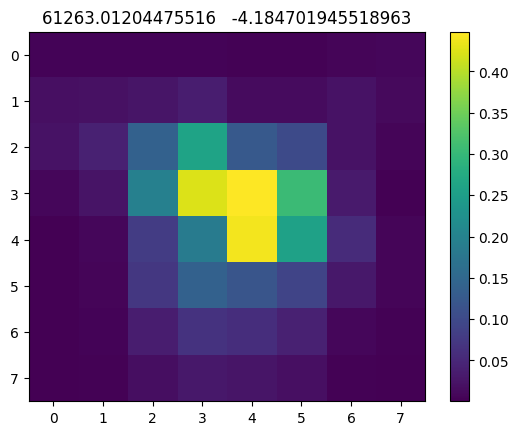

In [8]:
print( cp.sqrt(cp.nanmean( (data[sens_id]-cp.tensordot(weights,components,axes=([1], [0])))**2)))
print( cp.sqrt(cp.nanmean( (data[sens_id]-cp.tensordot(weights,components,axes=([1], [0])))**2)))
for ii in range(components.shape[0]):
    plt.figure()
    plt.imshow(-components[ii,...].get(), aspect='auto')
    plt.colorbar()
    # plt.figure()
    # plt.imshow(cp.log(cp.nanmean(data[sens_id],0)).get())
    # plt.colorbar()
    # plt.figure()
    # plt.imshow(cp.log(-components[ii,...]).get(), aspect='auto')
    # plt.colorbar()
    # plt.figure()
    # plt.imshow(cp.mean(cp.isnan(data[sens_id]),0).get())
    # plt.colorbar()
    # plt.figure()
    #plt.imshow(cp.log(-components[ii,...]/cp.nanmean(data[sens_id],0)).get(), aspect='auto')
    #plt.colorbar()
    plt.title(str(kgs.rms(weights[:,ii]).get())+'   '+str(cp.sum(components[ii,...]).get()))

In [9]:
np.exp(0.150), 31169.300527217067/26805

(1.161834242728283, 1.1628166583554214)

(32643, 17)
(17, 17)
(32643, 17)
(17, 17)


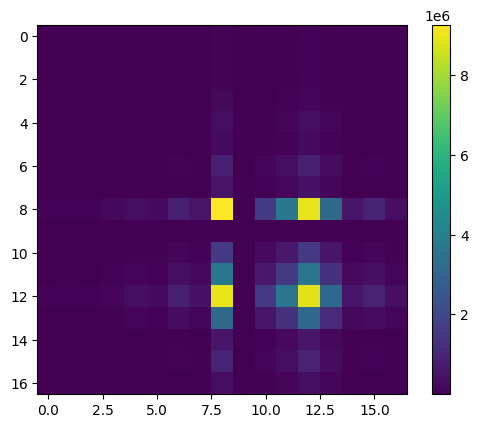

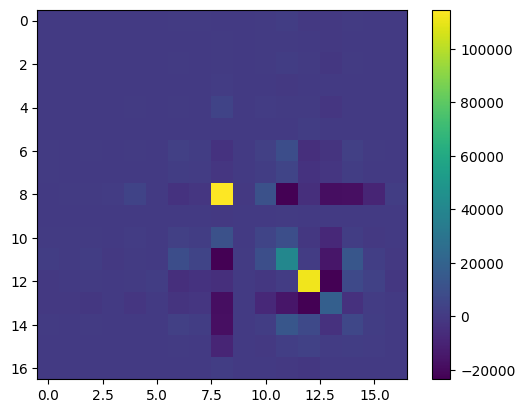

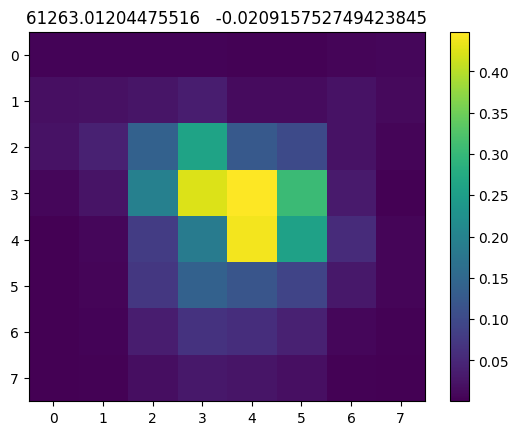

(32643, 17)
(17, 17)


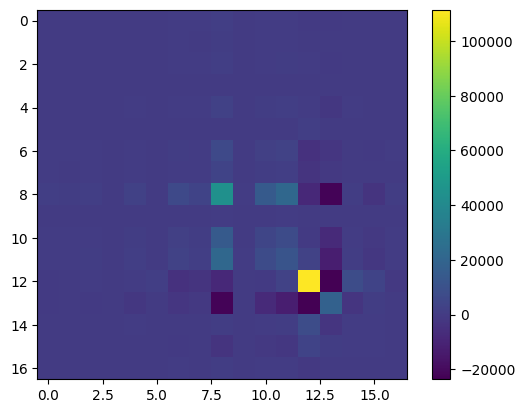

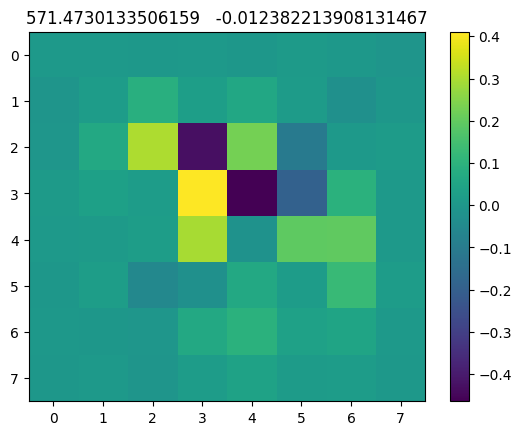

(32643, 17)
(17, 17)


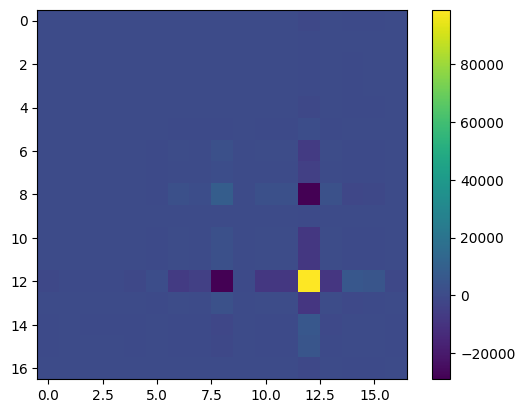

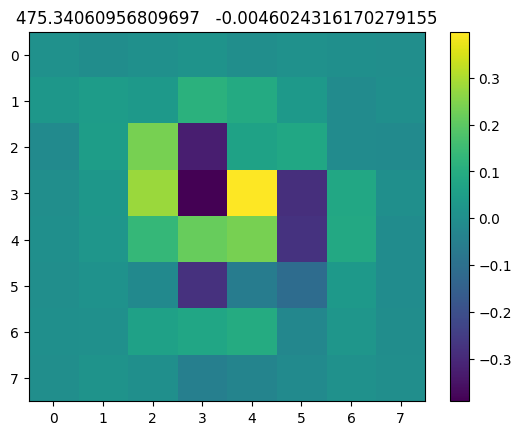

(32643, 17)
(17, 17)


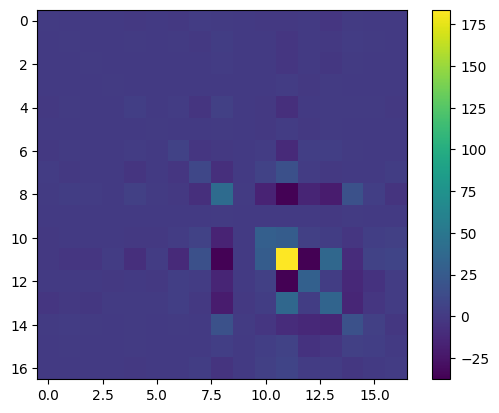

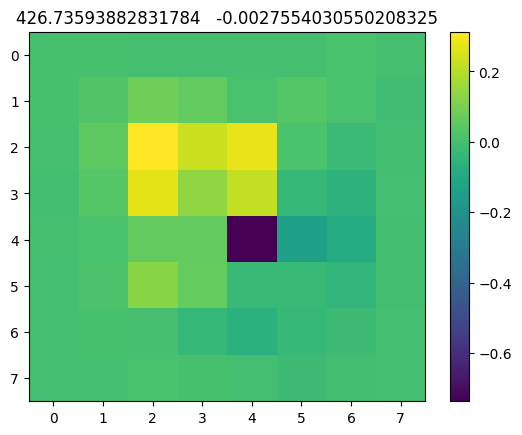

(32643, 17)
(17, 17)


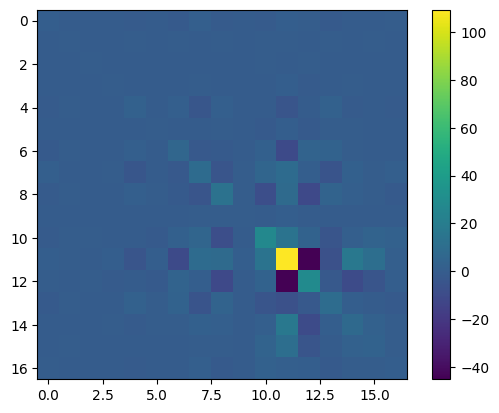

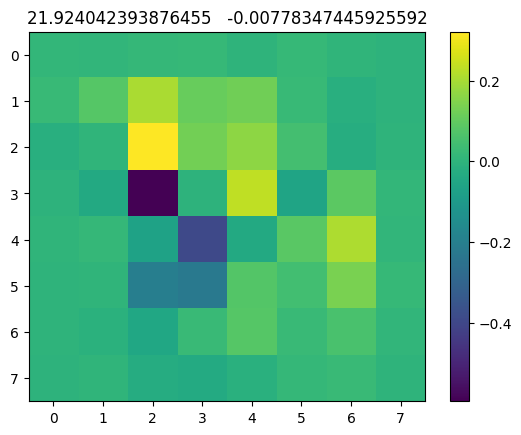

(32643, 17)
(17, 17)


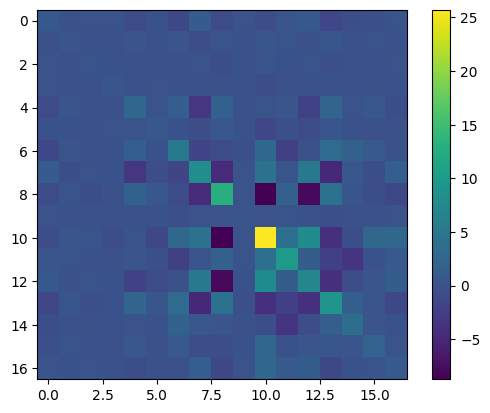

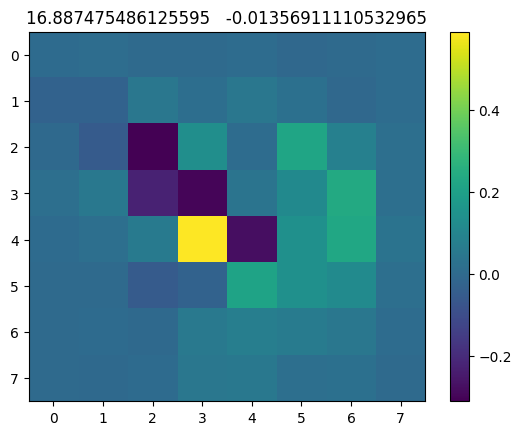

(32643, 17)
(17, 17)


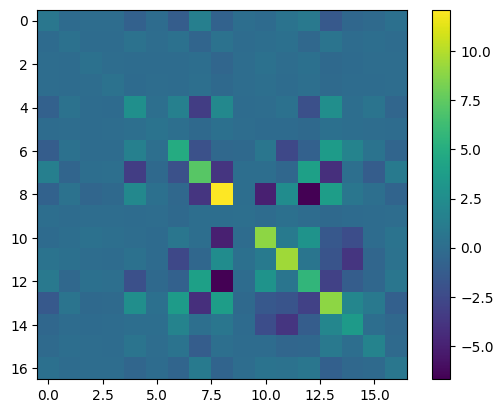

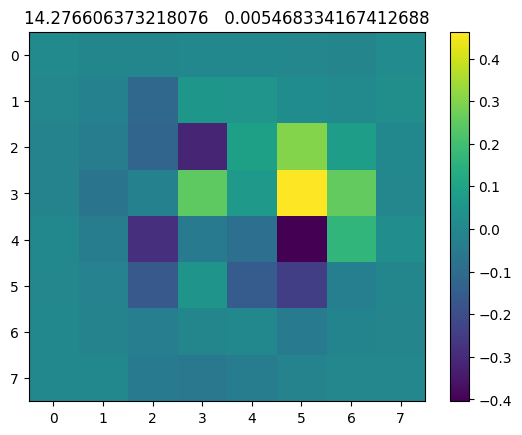

(32643, 17)
(17, 17)


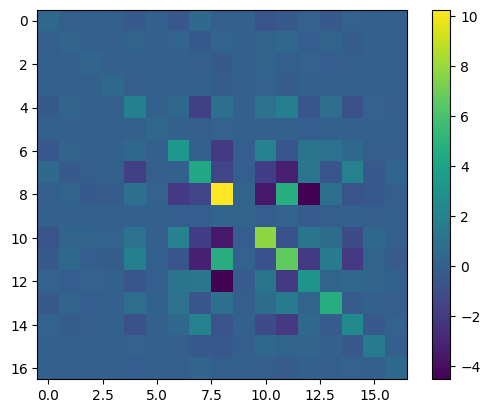

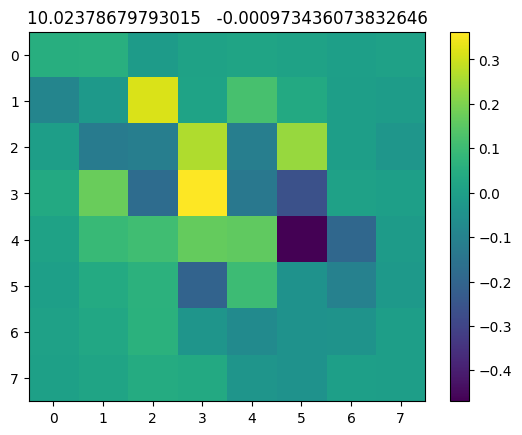

(32643, 17)
(17, 17)


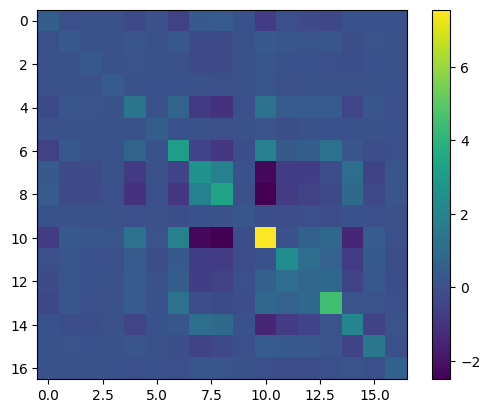

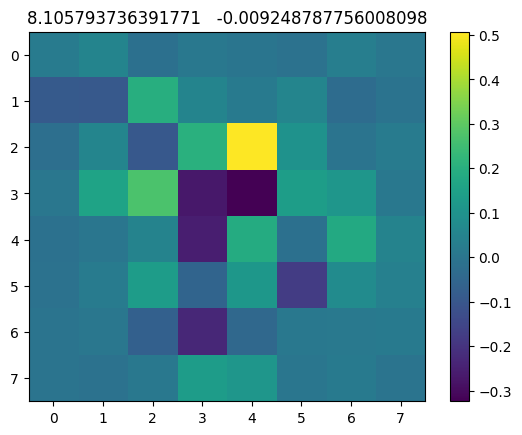

(32643, 17)
(17, 17)


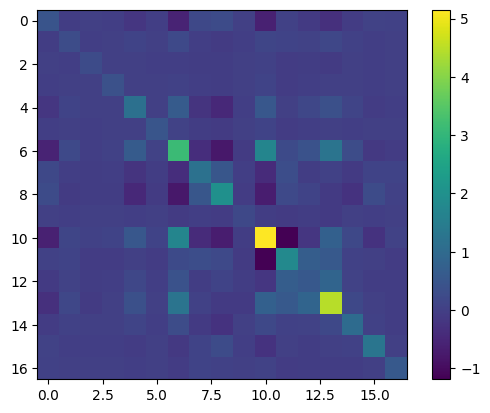

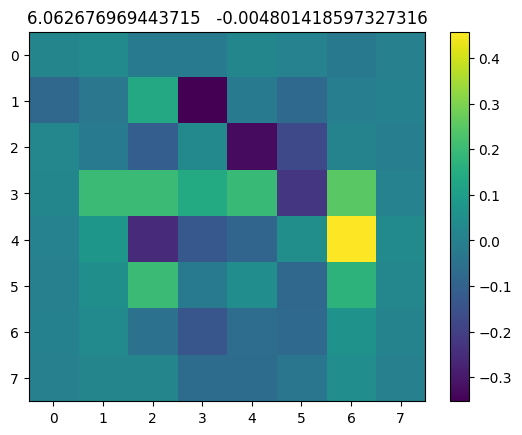

(32643, 17)
(17, 17)


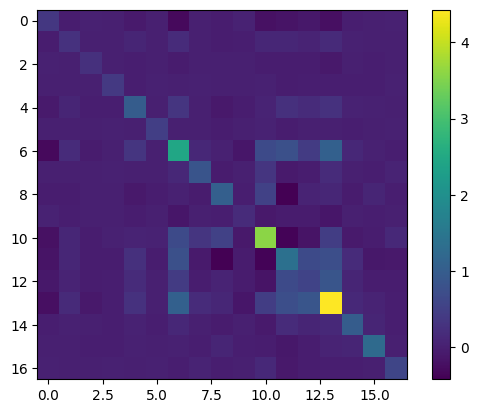

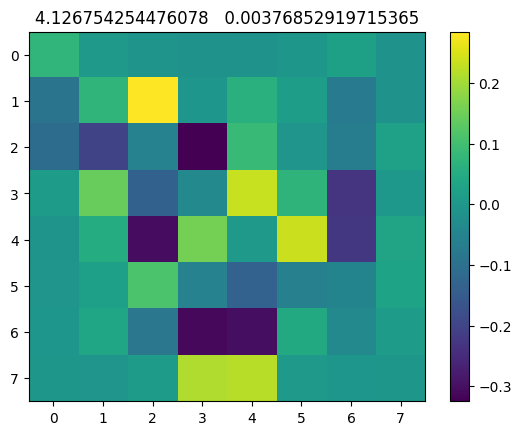

(32643, 17)
(17, 17)


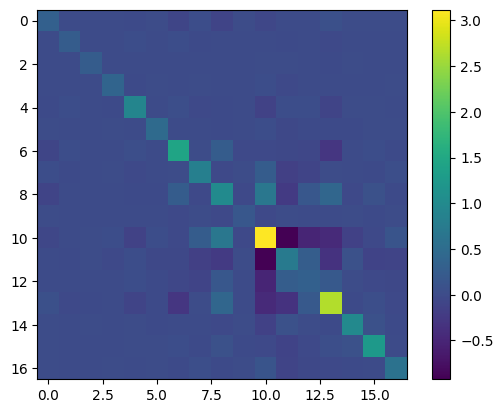

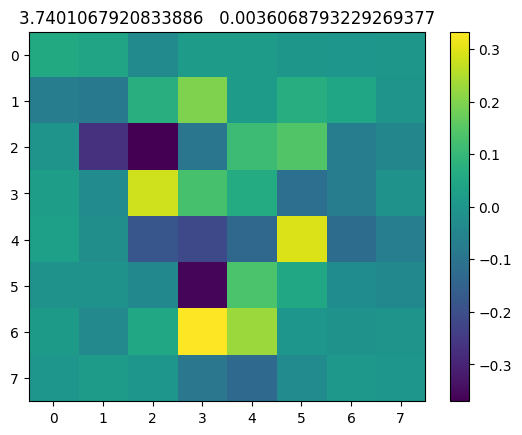

(32643, 17)
(17, 17)


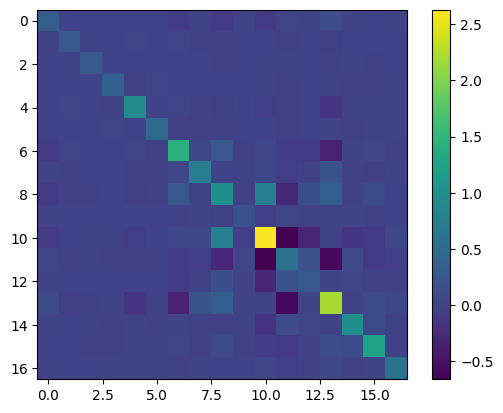

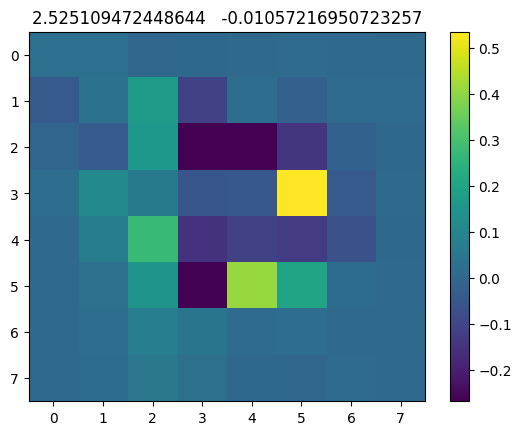

(32643, 17)
(17, 17)


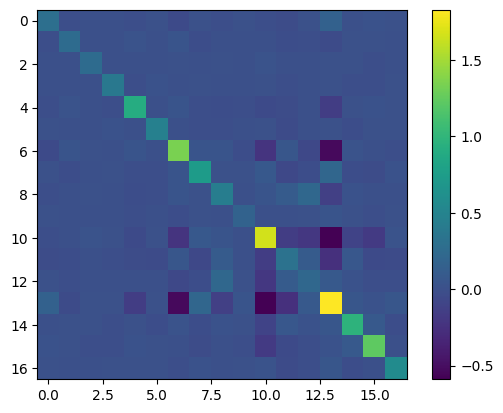

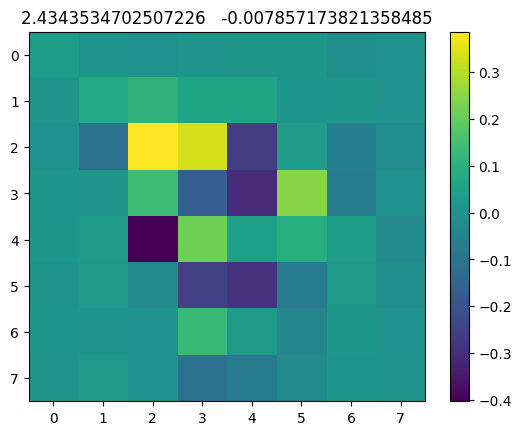

(32643, 17)
(17, 17)


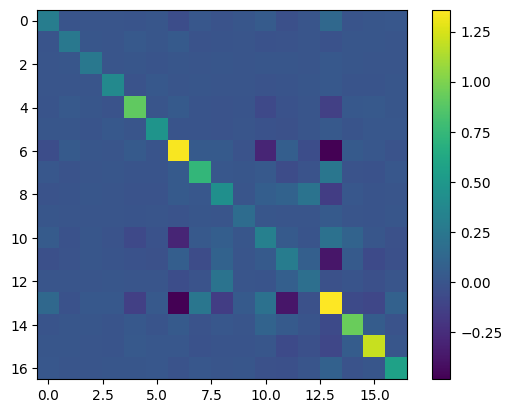

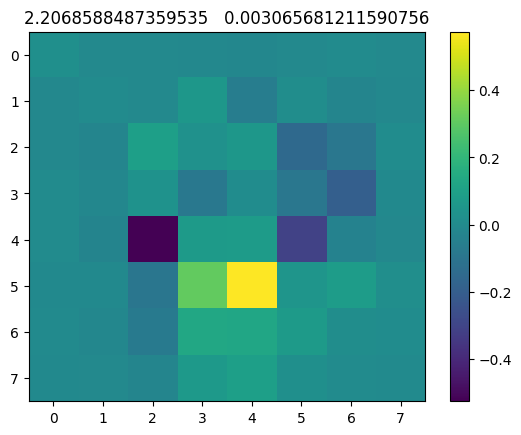

(32643, 17)
(17, 17)


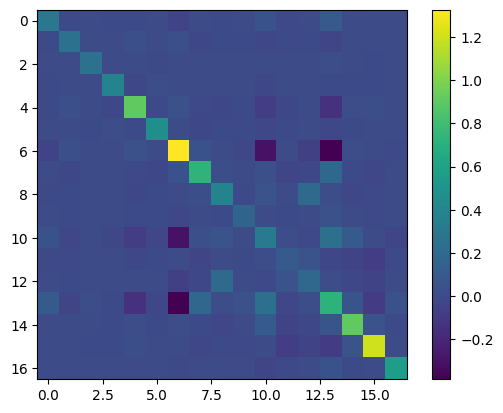

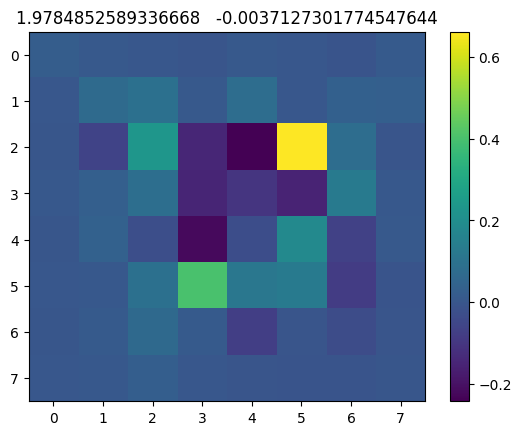

(32643, 17)
(17, 17)


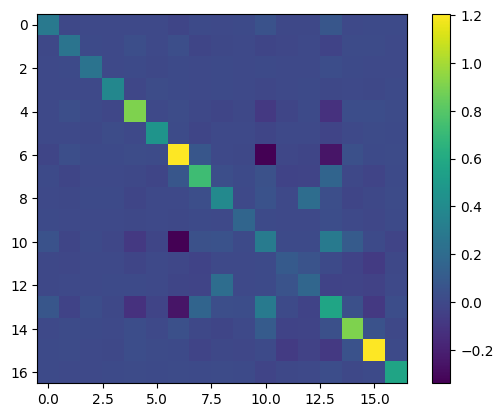

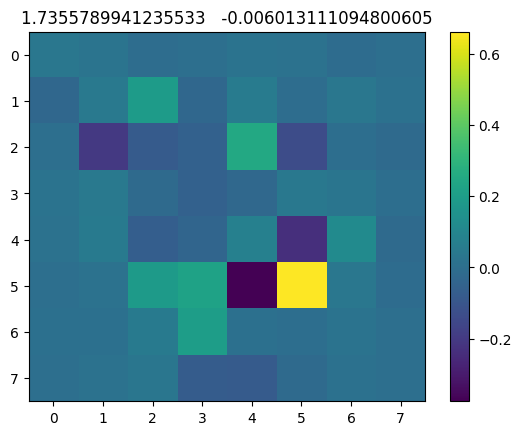

(32643, 17)
(17, 17)


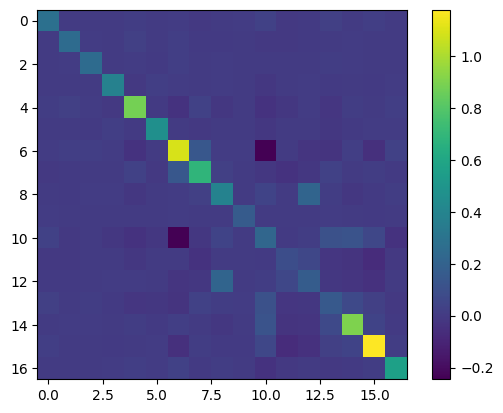

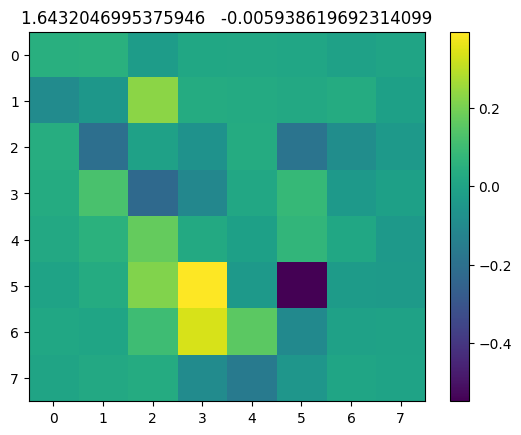

(32643, 17)
(17, 17)


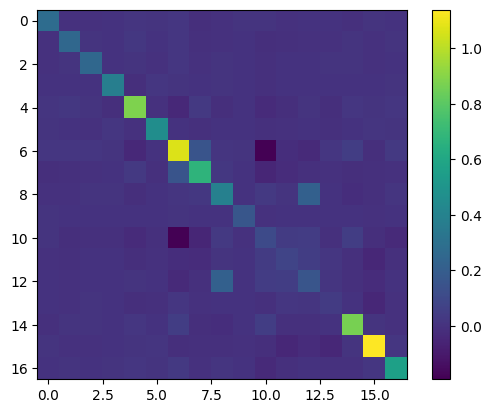

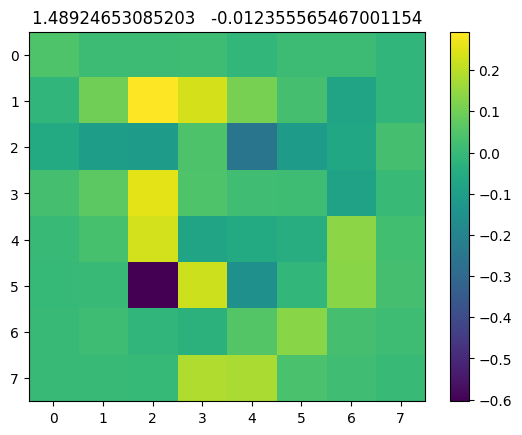

(32643, 17)
(17, 17)


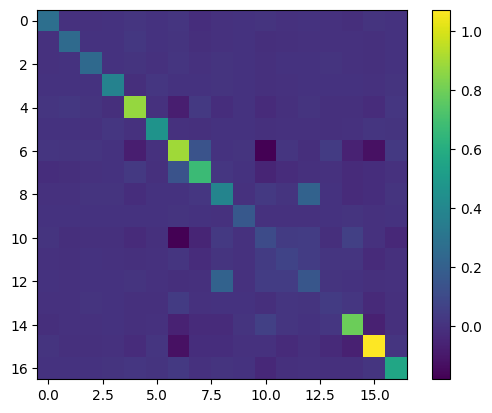

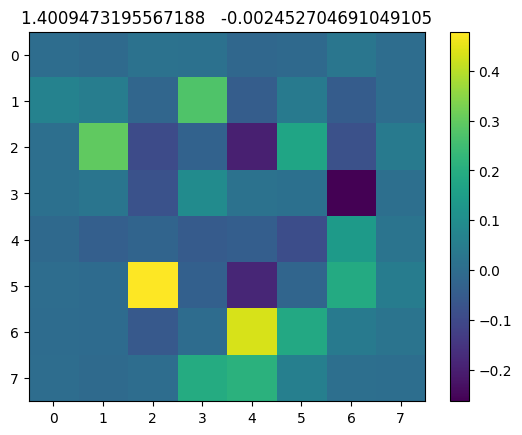

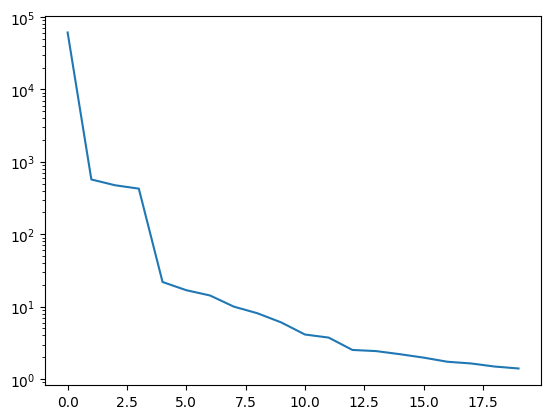

In [12]:
def show_cov(dat):
    flat = dat.reshape((dat.shape[0],-1))
    flat = flat[:,~cp.any(cp.isnan(flat),0)]
    print(flat.shape)
    print(cp.cov(flat.T).shape)
    plt.figure()
    plt.imshow(cp.cov(flat.T).get())
    plt.colorbar()
dat = copy.deepcopy(data[sens_id])
show_cov(dat)
SS = []
for ii in range(20):
    weights,components,S = nan_pca(dat, 1, tol=1e-5, verbose=False)
    dat = dat - cp.tensordot(weights,components,axes=([1], [0]))
    show_cov(dat)
    plt.figure()
    plt.imshow(-components[0,...].get(), aspect='auto')
    plt.colorbar()
    plt.title(str(kgs.rms(weights[:,0]).get())+'   '+str(cp.median(components[0,...]).get()))
    plt.pause(0.001)
    SS.append(kgs.rms(weights[:,0]).get())
plt.figure()
plt.semilogy(SS)

In [ ]:
# n_samples = 1000
# n_features = 100
# n_comp = 1
# noise_fac = 1
# nan_fac=0.9
# C_test = cp.random.default_rng(seed=0).standard_normal(size=(n_comp,n_features))
# W_test = cp.random.default_rng(seed=0).standard_normal(size=(n_samples,n_comp))
# data = W_test@C_test
# data += noise_fac*cp.random.default_rng(seed=0).standard_normal(size=data.shape)
# data[cp.random.default_rng(seed=0).uniform(size=data.shape)<nan_fac] = cp.nan
# weights,components,S=nan_pca(data,1,verbose=True)
# #kgs.rms(components/kgs.rms(components)-C_test/kgs.rms(C_test))
# cp.sqrt(cp.nanmean( (data)**2 )), cp.sqrt(cp.nanmean( (data-weights@components)**2 )), cp.sqrt(cp.nanmean( (data-W_test@C_test)**2 ))

In [ ]:
kgs.rms(C_test)